In [39]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
%cd drive/My Drive/robot

[Errno 2] No such file or directory: 'drive/My Drive/robot'
/content/drive/My Drive/robot


In [40]:
!ls

canny.jpg  CVC-FP  hough.jpg  images  ImagesGT	linesDetected.jpg  occmap.ipynb


In [0]:
def findmap(img_vh):
  h, w = img_vh.shape
  l = w
  r = 0
  t = h
  b = 0
  min1 = max(h,w)
  min2 = max(h,w)

  for i in range(h//3):
    unique1, counts1 = np.unique(img_vh[i,:], return_counts=True)

    if min1 >= counts1[0]:
      min1 = counts1[0]
      l = i
    unique2, counts2 = np.unique(img_vh[h-i-1,:], return_counts=True)
    if min2 >= counts2[0]:
      min2 = counts2[0]
      r = h-i

  min1 = max(h,w)
  min2 = max(h,w)
  for i in range(w//3):
    unique1, counts1 = np.unique(img_vh[:,i], return_counts=True)

    if min1 >= counts1[0]:
      min1 = counts1[0]
      t = i

    unique2, counts2 = np.unique(img_vh[:,w-i-1], return_counts=True)

    if min2 >= counts2[0]:
      min2 = counts2[0]
      b = w-i
  #return l,r,t,b
  return t, l, b, r

findmap(img_vh)

(16, 0, 726, 602)

In [0]:
def find_img_vh(file):
  img = cv2.imread(file,0)
  img.shape
  #thresholding the image to a binary image
  thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
  #inverting the image 
  img_bin = 255-img_bin

  # Length(width) of kernel as 100th of total width
  kernel_len = np.array(img).shape[1]//100
  # Defining a vertical kernel to detect all vertical lines of image 
  ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
  # Defining a horizontal kernel to detect all horizontal lines of image
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
  # A kernel of 2x2
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

  #Use vertical kernel to detect and save the vertical lines in a jpg
  image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
  vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

  #Use horizontal kernel to detect and save the horizontal lines in a jpg
  image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
  horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

  # Combine horizontal and vertical lines in a new third image, with both having same weight.
  img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
  #Eroding and thesholding the image
  img_vh = cv2.erode(~img_vh, kernel, iterations=2)
  thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return img_vh

def crop_map(file):
  img_vh = find_img_vh(file)
  x1,y1,x2,y2=findmap(img_vh)
  img = cv2.imread(file,1)
  return img[y1:y2, x1:x2]


def occ_map(file):
  img = crop_map(file)

  gray=cv2.threshold(img,200,255,cv2.THRESH_BINARY)[1]
  #gray=cv2.blur(gray,(15,1))
  dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
  #dilate = cv2.erode(th, dilate_kernel, iterations=1)

  dilate = cv2.dilate(gray, dilate_kernel, iterations=1)
  dilate=cv2.cvtColor(dilate,cv2.COLOR_BGR2GRAY)
  contours,hierarchy = cv2.findContours(dilate,cv2.RETR_TREE ,cv2.CHAIN_APPROX_NONE )
  drawing = np.zeros(img.shape, np.uint8)
  h,w,c = drawing.shape
  min_area = h*w//100
  for cnt in contours:
      area = cv2.contourArea(cnt)
      if area>min_area:
          cv2.drawContours(drawing,[cnt],0,(255,0,0),1)

  cv2_imshow(drawing)

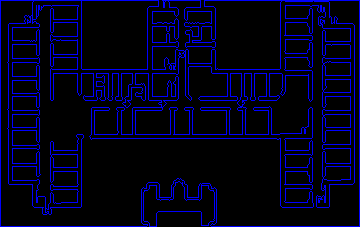

In [56]:
occ_map('images/map3.jpg')